In [43]:
# install all the necessary packages
# !pip install scipy pandas seaborn matplotlib scikit-learn numpy
from scipy.io import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import numpy as np
import math
from numpy.linalg import linalg

# ignore deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

(a) Download the Vertebral Column Data Set from: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column

In [44]:
# load raw dataset from an .arff file
# we only focus on the 2-class classification problem, so load the 2c dataset
data, meta = arff.loadarff("../data/vertebral_column_data/column_2C_weka.arff")

# convert raw data to a pandas dataframe and check the data
df = pd.DataFrame(data)
# print(df)

# decode the column 'class'(bytes) into strings and check the data again
df["class"] = df["class"].apply(lambda x: x.decode("utf-8"))
print(df)

     pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0           63.027817    22.552586              39.609117     40.475232   
1           39.056951    10.060991              25.015378     28.995960   
2           68.832021    22.218482              50.092194     46.613539   
3           69.297008    24.652878              44.311238     44.644130   
4           49.712859     9.652075              28.317406     40.060784   
..                ...          ...                    ...           ...   
305         47.903565    13.616688              36.000000     34.286877   
306         53.936748    20.721496              29.220534     33.215251   
307         61.446597    22.694968              46.170347     38.751628   
308         45.252792     8.693157              41.583126     36.559635   
309         33.841641     5.073991              36.641233     28.767649   

     pelvic_radius  degree_spondylolisthesis     class  
0        98.672917                 -0.2544

(b) Pre-Processing and Exploratory data analysis:

i. Make scatterplots of the independent variables in the dataset. Use color to
show Classes 0 and 1

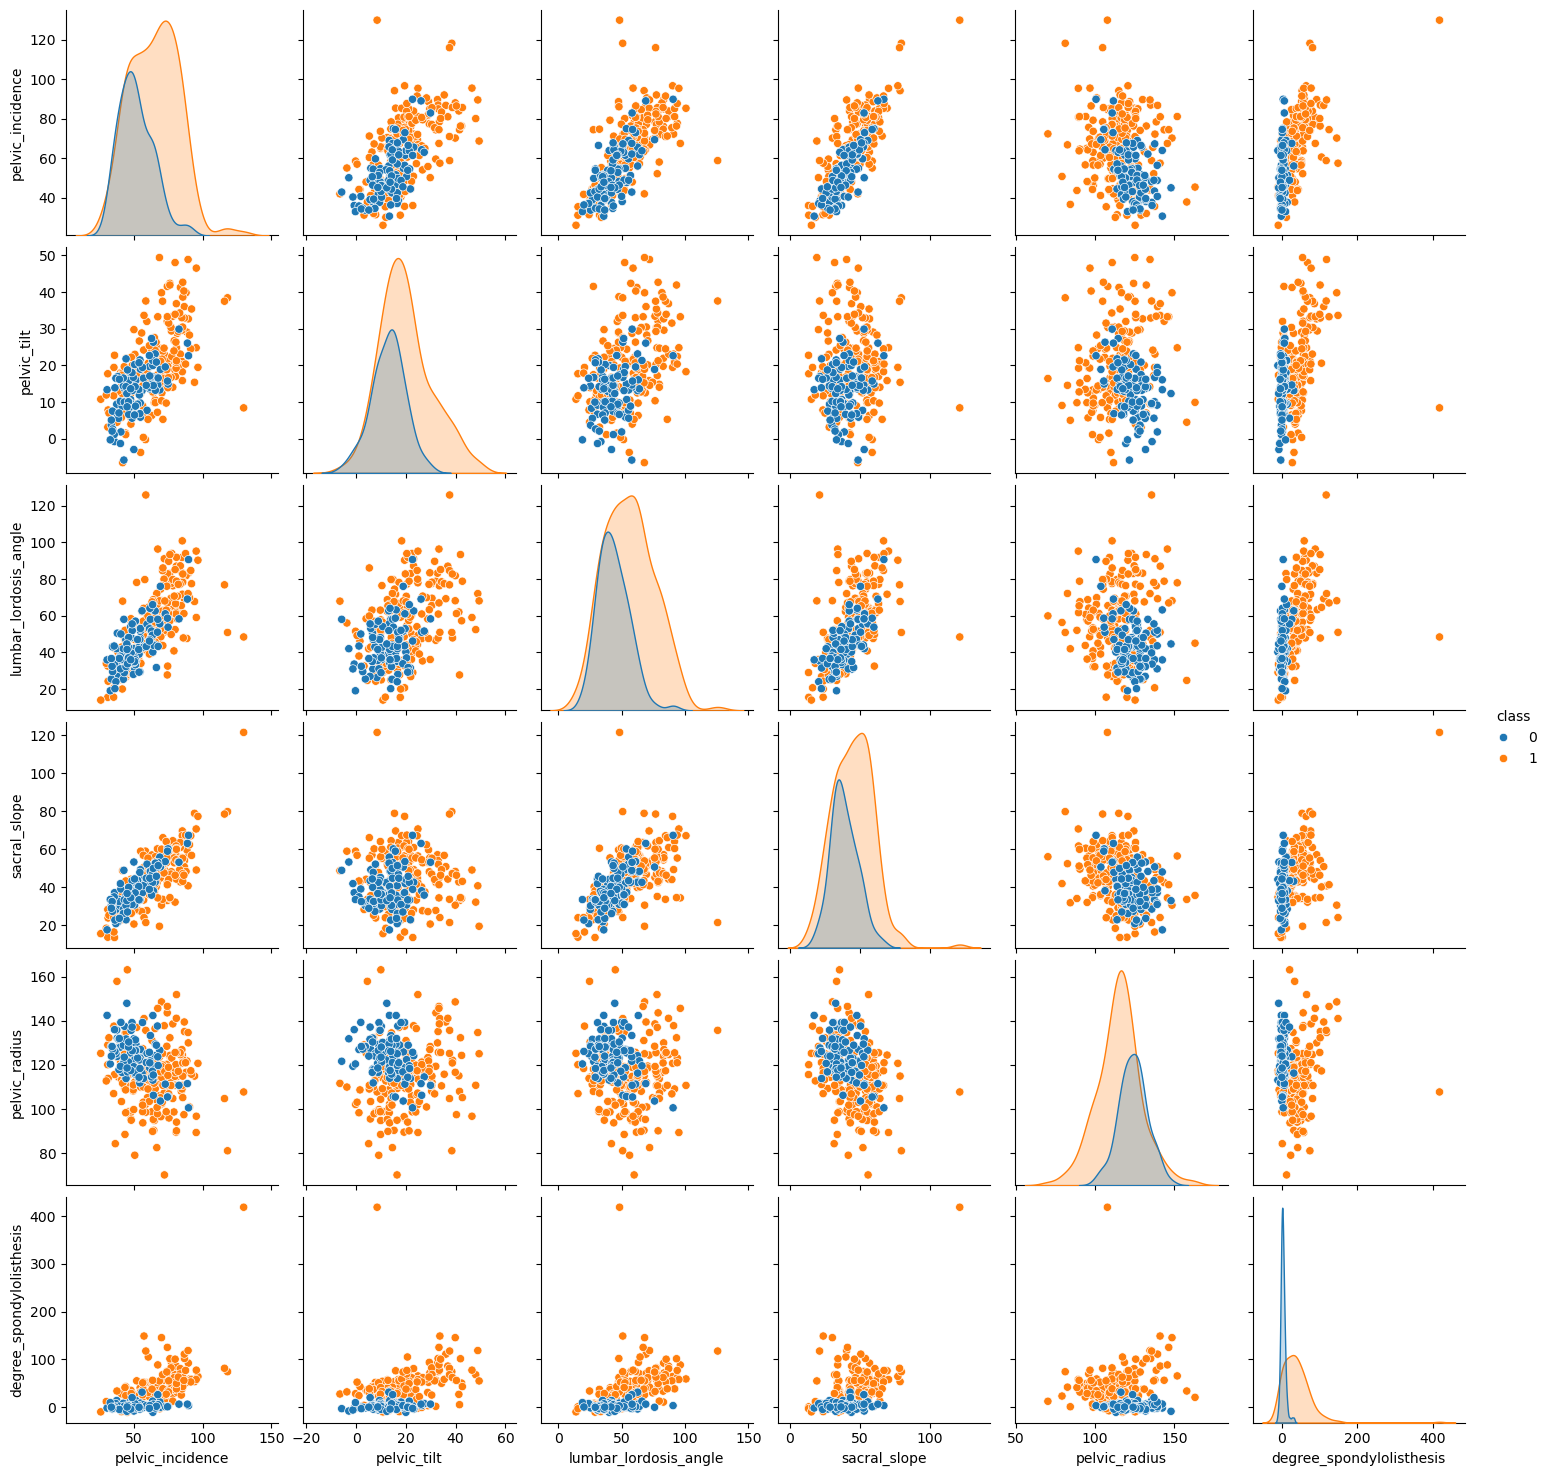

In [45]:
# convert labels of class to 0 and 1 (Normal = 0, Abnormal = 1), and check
label_to_num = {"Normal": 0, "Abnormal": 1}
df["class"] = df["class"].map(label_to_num)
# print(df)

# scatterplots of the indenpendent variables
sns.pairplot(df, hue="class")

ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1

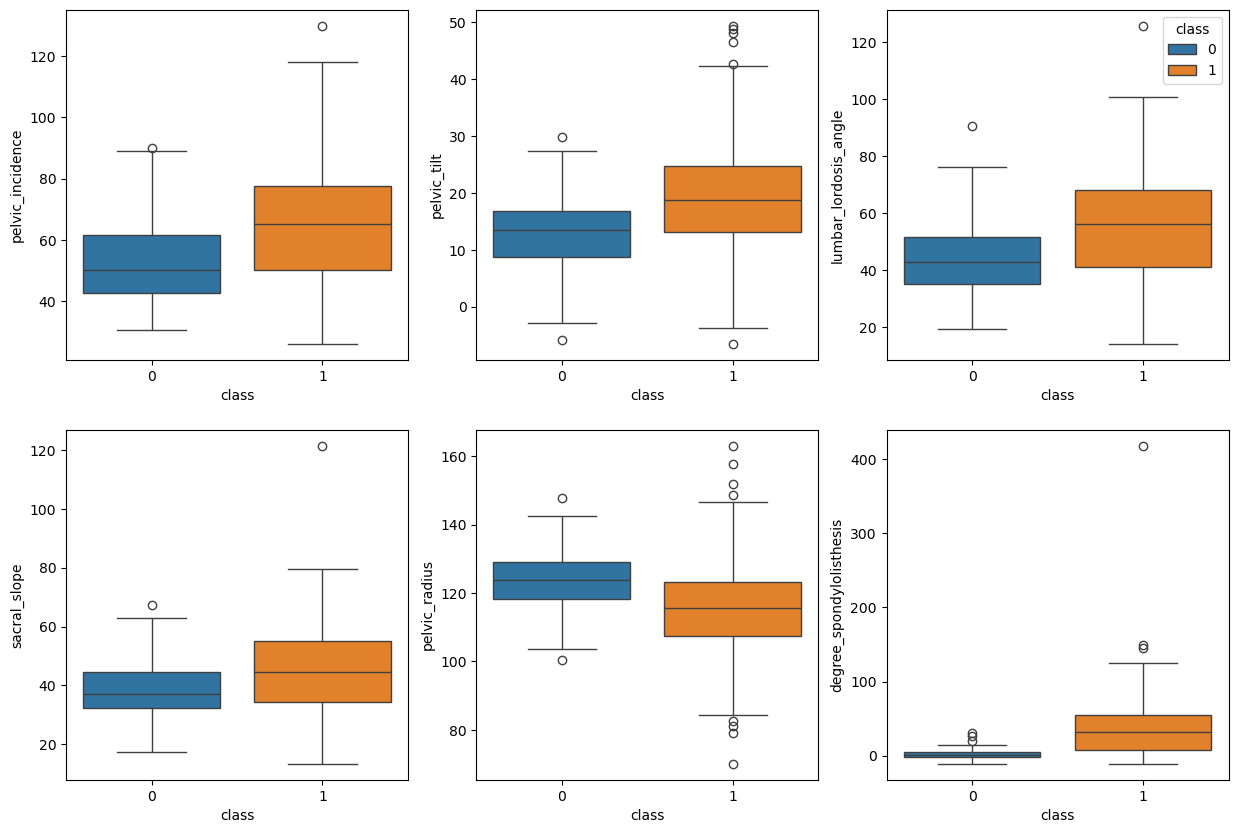

In [46]:
# boxplots of the independent variables
var = df.columns[:6]  # get the names of the independent variables
# print(var)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, j in enumerate(var):
    ax = axes.flat[i]  # get the current axis
    sns.boxplot(
        data=df, x="class", y=j, hue="class", ax=ax, legend=(i == 2)
    )  # only show legend in the third subplot

plt.show()

iii. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set

In [47]:
# split the dataset into training set and test set
train_df = df.groupby("class", group_keys=False).apply(
    lambda x: x.head(70 if x.name == 0 else 140)
)
test_df = df.drop(train_df.index)
print(train_df)
print(test_df)

# get the features and labels
X_train = train_df[df.columns[:6]]
y_train = train_df[["class"]].to_numpy().ravel() #convert to 1-d array

X_test = test_df[df.columns[:6]]
y_test = test_df[["class"]].to_numpy().ravel()

# # standardize the features
# ss= StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)   


     pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
210         38.505273    16.964297              35.112814     21.540976   
211         54.920858    18.968430              51.601455     35.952428   
212         44.362490     8.945435              46.902096     35.417055   
213         48.318931    17.452121              48.000000     30.866809   
214         45.701789    10.659859              42.577846     35.041929   
..                ...          ...                    ...           ...   
135         77.121344    30.349874              77.481083     46.771470   
136         88.024499    39.844669              81.774473     48.179830   
137         83.396606    34.310989              78.423293     49.085617   
138         72.054034    24.700737              79.874016     47.353297   
139         85.095503    21.069897              91.734792     64.025606   

     pelvic_radius  degree_spondylolisthesis  class  
210     127.632875                  7.986683 

(c) Classification using KNN on Vertebral Column Data Set

i. Write code for k-nearest neighbors with Euclidean metric (or use a softwarepackage)

In [48]:
# use sklearn to implement KNN classification
# define a function to evaluate KNN classifier with different parameters


def evaluate_knn(
    *args,  # X_train, y_train, X_test, y_test
    k_list=None,  # list of k values, default is [1, 6, 11, ..., 196](list of n_neighbors)
    weights="uniform",  # {"uniform", "distance"}, default is "uniform"
    metric="euclidean",  # Metric to use for distance computation, {"euclidean", "minkowski","chebyshev", "mahalanobis"}, default is "euclidean"
    metric_params=None,  # additional parameters for the metric function, default value is None
    p=2,  # power parameter for the Minkowski metric, default is 2(euclidean)
):

    X_train, y_train, X_test, y_test = args

    if k_list is None:
        k_list = list(range(1, 197, 5))

    train_errors = []
    test_errors = []
    performance = []

    # iterate over different k values
    for k in k_list:

        # create the KNN classifier
        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights=weights,
            metric=metric,
            metric_params=None if metric_params is None else metric_params,
            p=2 if p is None else p,
        )
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)

        # calculate training error, test error, precision, recall, f1 score
        train_err = 1.0-accuracy_score(y_train, y_train_pred)
        test_err =  1.0-accuracy_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)

        train_errors.append(train_err)
        test_errors.append(test_err)

        performance.append({
            "k": k,
            "train_error": train_err,
            "test_error": test_err,
            "precision": prec,
            "recall": rec,
            "f1_score": f1
        })
    per_df = pd.DataFrame(performance)
    print(per_df) # print the performance table
   
    # find the best k (with the lowest test error)
    min_train_err = min(train_errors)
    min_test_err = min(test_errors)
    best_k = [k for k, e in zip(k_list, test_errors) if e == min_test_err]

    # return the function results
    return {
        "best_k": best_k,
        "model": metric,
        "min_train_err": min_train_err,
        "min_test_err": min_test_err,
        "train_errors": train_errors,
        "test_errors": test_errors,
    }

In [49]:
# create a list to store all the minimum training errors of each model
sum_min_train_errors = []

ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈{208, 205, . . . , 7, 4, 1, }(in reverse order). You are welcome to use smaller
increments of k. Which k∗ is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision, and F1-score when k= k*

      k  train_error  test_error  precision    recall  f1_score
0   208     0.333333        0.30   0.700000  1.000000  0.823529
1   205     0.333333        0.30   0.700000  1.000000  0.823529
2   202     0.333333        0.30   0.700000  1.000000  0.823529
3   199     0.333333        0.30   0.700000  1.000000  0.823529
4   196     0.333333        0.30   0.700000  1.000000  0.823529
..  ...          ...         ...        ...       ...       ...
65   13     0.142857        0.12   0.853659  1.000000  0.921053
66   10     0.133333        0.10   0.875000  1.000000  0.933333
67    7     0.142857        0.12   0.853659  1.000000  0.921053
68    4     0.142857        0.06   0.932432  0.985714  0.958333
69    1     0.000000        0.13   0.870130  0.957143  0.911565

[70 rows x 6 columns]

When k = 4 , the minimum test error is 0.06000000000000005


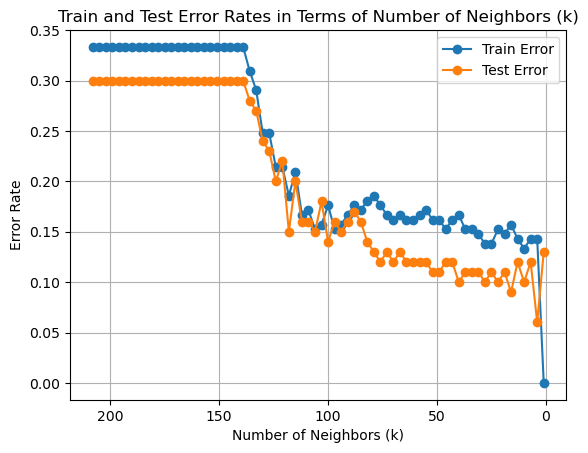

In [50]:
# KNN with euclidean distance and majority voting
k_ls = list(range(208, 0, -3))
knn_eu = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=k_ls,
    weights="uniform",
    metric="euclidean",
    metric_params=None,
    p=2,
)
print(
    "\nWhen k =",
    *knn_eu["best_k"],
    ", the minimum test error is",
    knn_eu["min_test_err"],
)
sum_min_train_errors.append(knn_eu["min_train_err"])

# plot the training and test errors vs. k
plt.plot(k_ls, knn_eu["train_errors"], label="Train Error", marker="o")
plt.plot(k_ls, knn_eu["test_errors"], label="Test Error", marker="o")
plt.title("Train and Test Error Rates in Terms of Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error Rate")
plt.legend()
plt.grid()
plt.gca().invert_xaxis()
plt.show()

In [51]:
#  calculate the confusion matrix, true positive rate, true negative rate, precision, and F1-score for the best model
knn_eu_4 = KNeighborsClassifier(
    n_neighbors=knn_eu["best_k"][0], metric="euclidean", p=2
)
knn_eu_4.fit(X_train, y_train)

y_test_pred = knn_eu_4.predict(X_test)

confusion_ma = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_ma.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
pr = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Confusion Matrix:\n{confusion_ma}")
print(f"True Positive Rate: {tpr}")
print(f"True Negative Rate: {tnr}")
print(f"Precision: {pr}")
print(f"F1-Score: {f1}")

Confusion Matrix:
[[25  5]
 [ 1 69]]
True Positive Rate: 0.9857142857142858
True Negative Rate: 0.8333333333333334
Precision: 0.9324324324324325
F1-Score: 0.9583333333333334


 Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error rate, which is obtained by some value of k, against the size of training set, when the size of training set is N ∈{10, 20, 30, . . . , 210}. 
 Note: for each N , select your training set by choosing the first ⌊N/3⌋rows of Class 0 and the first N −⌊N/3⌋rows of Class 1 in the training set you created in 1(b)iii. Also, for each N , select the optimal k from a set starting from k = 1, increasing by 5.
 For example, if N = 200, the optimal k is selected from {1, 6, 11, . . . , 196}.This plot is called a Learning Curve.

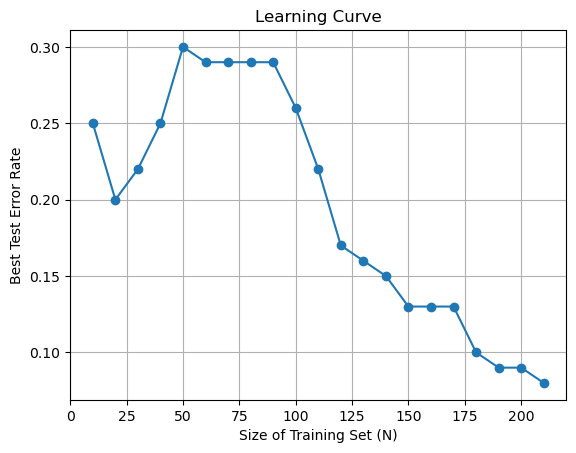

In [52]:
# vary the size of the training set
n_size = list(range(10, 211, 10))
best_test_errors = []

for i in n_size:
    # create a new training set with size i
    n = i // 3
    n_train_df = train_df.groupby("class", group_keys=False).apply(
        lambda x: x.head(n if x.name == 0 else (i - n))
    )
    n_X_train = n_train_df[df.columns[:6]]
    #n_X_train = ss.fit_transform(n_X_train)
    n_y_train = n_train_df[["class"]].to_numpy().ravel()

    n_train_errors = []
    n_test_error = []

    # KNN with euclidean distance and majority voting
    k_ls = range(1, i, 5)
    for k in k_ls:
        n_knn_eu = KNeighborsClassifier(n_neighbors=k, metric="euclidean", p=2)
        n_knn_eu.fit(n_X_train, n_y_train)

        n_y_train_pred = n_knn_eu.predict(n_X_train)
        y_test_pred = n_knn_eu.predict(X_test)

        n_train_err = 1.0 - accuracy_score(n_y_train, n_y_train_pred)
        n_test_err = 1.0 - accuracy_score(y_test, y_test_pred)

        n_train_errors.append(n_train_err)
        n_test_error.append(n_test_err)

    sum_min_train_errors.append(min(n_train_errors))
    best_test_errors.append(min(n_test_error))

# plot the learning curve
plt.plot(n_size, best_test_errors, marker="o")
plt.xlabel("Size of Training Set (N)")
plt.ylabel("Best Test Error Rate")
plt.title("Learning Curve")
plt.grid()
plt.show()

(d) Replace the Euclidean metric with the following metrics5 and test them. Summarize the test errors (i.e., when k= k∗) in a table. Use all of your training data and select the best k when {1, 6, 11, . . . , 196}

i. Minkowski Distance:

A. which becomes Manhattan Distance with p = 1.

In [53]:
# KNN with Manhattan distance and majority voting
knn_man = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="uniform",
    metric="minkowski",
    metric_params=None,
    p=1,
)

print(
    "\nWhen k =",
    *knn_man["best_k"],
    ", the minimum test error is",
    knn_man["min_test_err"],
)
sum_min_train_errors.append(knn_man["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1     0.000000        0.11   0.883117  0.971429  0.925170
1     6     0.138095        0.11   0.893333  0.957143  0.924138
2    11     0.142857        0.11   0.873418  0.985714  0.926174
3    16     0.133333        0.12   0.862500  0.985714  0.920000
4    21     0.147619        0.12   0.862500  0.985714  0.920000
5    26     0.166667        0.11   0.873418  0.985714  0.926174
6    31     0.166667        0.12   0.862500  0.985714  0.920000
7    36     0.161905        0.13   0.860759  0.971429  0.912752
8    41     0.166667        0.13   0.860759  0.971429  0.912752
9    46     0.171429        0.13   0.860759  0.971429  0.912752
10   51     0.171429        0.14   0.850000  0.971429  0.906667
11   56     0.185714        0.13   0.860759  0.971429  0.912752
12   61     0.176190        0.15   0.839506  0.971429  0.900662
13   66     0.185714        0.15   0.839506  0.971429  0.900662
14   71     0.176190        0.14   0.841

B. with log10(p) ∈{0.1, 0.2, 0.3, . . . , 1}. In this case, use the k∗ you found for the Manhattan distance in 1(d)iA. What is the best log10(p)?

In 1(d)iB, I choose K=6 as the number of neighbors. I tried k ∈ {1,6,11,26} and found out when K = 6, the model got the minimum test error(0.06). When K ∈ {1,11}, the minimum errors both equal to 0.11. When k = 26, the minimum error = 0.10

In [54]:
# create the list of p values
log10_p_list = np.arange(0.1, 1.1, 0.1)
p_ls = [10**val for val in log10_p_list]

train_errors = []
test_errors = []
results = []

for p in p_ls:
    # KNN with Manhattan distance and majority voting(k=6, when k = 6, the model has the minmum test error)
    knn_p = KNeighborsClassifier(n_neighbors=6, metric="minkowski", p=p)
    knn_p.fit(X_train, y_train)

    y_train_pred = knn_p.predict(X_train)
    y_test_pred = knn_p.predict(X_test)

    train_err = 1 - accuracy_score(y_train, y_train_pred)
    test_err = 1 - accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    train_errors.append(train_err)
    test_errors.append(test_err)
    results.append(
        {
            "p": p,
            "log10(p)": np.log10(p),
            "train_error": train_err,
            "test_error": test_err,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
        }
    )

results_df = pd.DataFrame(results)
print(results_df)

sum_min_train_errors.append(min(train_errors))
min_test_err = min(test_errors)
best_p = [p for p, e in zip(p_ls, test_errors) if e == min_test_err]
best_log10_p = [np.log10(p) for p in best_p]

print(
    "\nWhen log10(p) =",
    *best_log10_p,
    ", the minimum test error is",
    min_test_err
)

           p  log10(p)  train_error  test_error  precision    recall  f1_score
0   1.258925       0.1     0.138095        0.09   0.906667  0.971429  0.937931
1   1.584893       0.2     0.147619        0.09   0.896104  0.985714  0.938776
2   1.995262       0.3     0.147619        0.08   0.897436  1.000000  0.945946
3   2.511886       0.4     0.152381        0.08   0.897436  1.000000  0.945946
4   3.162278       0.5     0.147619        0.08   0.907895  0.985714  0.945205
5   3.981072       0.6     0.152381        0.06   0.921053  1.000000  0.958904
6   5.011872       0.7     0.152381        0.07   0.920000  0.985714  0.951724
7   6.309573       0.8     0.147619        0.08   0.907895  0.985714  0.945205
8   7.943282       0.9     0.147619        0.09   0.896104  0.985714  0.938776
9  10.000000       1.0     0.133333        0.09   0.896104  0.985714  0.938776

When log10(p) = 0.6 , the minimum test error is 0.06000000000000005


C. which becomes Chebyshev Distance with p →∞

In [55]:
# KNN with Chebyshev distance and majority voting
knn_che = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="uniform",
    metric="chebyshev",
    metric_params=None,
    p=math.inf,
)

print(
    "\nWhen k =",
    *knn_che["best_k"],
    ", the minimum test error is",
    knn_che["min_test_err"],
)

sum_min_train_errors.append(knn_che["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1     0.000000        0.13   0.870130  0.957143  0.911565
1     6     0.152381        0.10   0.894737  0.971429  0.931507
2    11     0.161905        0.12   0.853659  1.000000  0.921053
3    16     0.147619        0.08   0.897436  1.000000  0.945946
4    21     0.133333        0.11   0.873418  0.985714  0.926174
5    26     0.157143        0.12   0.862500  0.985714  0.920000
6    31     0.142857        0.12   0.862500  0.985714  0.920000
7    36     0.157143        0.10   0.884615  0.985714  0.932432
8    41     0.142857        0.13   0.851852  0.985714  0.913907
9    46     0.161905        0.12   0.862500  0.985714  0.920000
10   51     0.166667        0.12   0.862500  0.985714  0.920000
11   56     0.166667        0.12   0.862500  0.985714  0.920000
12   61     0.176190        0.14   0.841463  0.985714  0.907895
13   66     0.161905        0.13   0.851852  0.985714  0.913907
14   71     0.180952        0.14   0.841

ii. Mahalanobis Distance.

In [56]:
# KNN with Mahalanobis distance and majority voting
S  = np.cov(X_train, rowvar=False)
VI = np.linalg.inv(S)

knn_maha = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="uniform",
    metric="mahalanobis",
    metric_params={"VI": VI},
    p=None,
)

print(
    "\nWhen k =",
    *knn_maha["best_k"],
    ", the minimum test error is",
    knn_maha["min_test_err"],
)

sum_min_train_errors.append(knn_maha["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1     0.000000        0.16   0.855263  0.928571  0.890411
1     6     0.133333        0.16   0.855263  0.928571  0.890411
2    11     0.171429        0.19   0.814815  0.942857  0.874172
3    16     0.171429        0.18   0.825000  0.942857  0.880000
4    21     0.157143        0.20   0.804878  0.942857  0.868421
5    26     0.161905        0.18   0.825000  0.942857  0.880000
6    31     0.161905        0.20   0.804878  0.942857  0.868421
7    36     0.161905        0.20   0.804878  0.942857  0.868421
8    41     0.176190        0.21   0.795181  0.942857  0.862745
9    46     0.180952        0.22   0.785714  0.942857  0.857143
10   51     0.180952        0.22   0.779070  0.957143  0.858974
11   56     0.176190        0.21   0.788235  0.957143  0.864516
12   61     0.180952        0.22   0.779070  0.957143  0.858974
13   66     0.180952        0.22   0.779070  0.957143  0.858974
14   71     0.180952        0.23   0.770

In [57]:
# summarize the best k and minumum test error of each model in (d)
sum_models = [
    [knn_eu["model"].capitalize(),   "/".join(map(str, knn_eu["best_k"])),   knn_eu["min_test_err"]],
    ["Manhattan",  "/".join(map(str, knn_man["best_k"])),  knn_man["min_test_err"]],
    [knn_che["model"].capitalize(),   "/".join(map(str, knn_che["best_k"])),   knn_che["min_test_err"]],
    [knn_maha["model"].capitalize(),  "/".join(map(str, knn_maha["best_k"])),  knn_maha["min_test_err"]],
]

columns = ["Model", "Best_k(s)", "Min_test_error"]

sum_models = pd.DataFrame(sum_models, columns=columns)
print(sum_models)

         Model  Best_k(s)  Min_test_error
0    Euclidean          4            0.06
1    Manhattan  1/6/11/26            0.11
2    Chebyshev         16            0.08
3  Mahalanobis        1/6            0.16


(e) The majority polling decision can be replaced by weighted decision, in which the
weight of each point in voting is inversely proportional to its distance from the
query/test data point. In this case, closer neighbors of a query point will have
a greater influence than neighbors which are further away. Use weighted voting
with Euclidean, Manhattan, and Chebyshev distances and report the best test
errors when k ∈{1, 6, 11, 16, . . . , 196}.

In [58]:
# KNN with Euclidean distance and distance-weighted voting
knn_eu_dis = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="distance",
    metric="euclidean",
    metric_params=None,
    p=2,
)

print(
    "\nWhen k =",
    *knn_eu_dis["best_k"],
    ", the minimum test error is",
    knn_eu_dis["min_test_err"],
)

sum_min_train_errors.append(knn_eu_dis["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1          0.0        0.13   0.870130  0.957143  0.911565
1     6          0.0        0.10   0.875000  1.000000  0.933333
2    11          0.0        0.12   0.853659  1.000000  0.921053
3    16          0.0        0.11   0.864198  1.000000  0.927152
4    21          0.0        0.11   0.873418  0.985714  0.926174
5    26          0.0        0.11   0.873418  0.985714  0.926174
6    31          0.0        0.11   0.873418  0.985714  0.926174
7    36          0.0        0.11   0.873418  0.985714  0.926174
8    41          0.0        0.11   0.873418  0.985714  0.926174
9    46          0.0        0.11   0.873418  0.985714  0.926174
10   51          0.0        0.11   0.873418  0.985714  0.926174
11   56          0.0        0.11   0.873418  0.985714  0.926174
12   61          0.0        0.11   0.873418  0.985714  0.926174
13   66          0.0        0.11   0.873418  0.985714  0.926174
14   71          0.0        0.11   0.873

In [59]:
# KNN with Manhattan distance and distance-weighted voting
knn_man_dis = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="distance",
    metric="minkowski",
    metric_params=None,
    p=1,
)

print(
    "\nWhen k =",
    *knn_man_dis["best_k"],
    ", the minimum test error is",
    knn_man_dis["min_test_err"],
)

sum_min_train_errors.append(knn_man_dis["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1          0.0        0.11   0.883117  0.971429  0.925170
1     6          0.0        0.11   0.873418  0.985714  0.926174
2    11          0.0        0.11   0.873418  0.985714  0.926174
3    16          0.0        0.12   0.862500  0.985714  0.920000
4    21          0.0        0.11   0.873418  0.985714  0.926174
5    26          0.0        0.10   0.884615  0.985714  0.932432
6    31          0.0        0.11   0.873418  0.985714  0.926174
7    36          0.0        0.11   0.873418  0.985714  0.926174
8    41          0.0        0.11   0.873418  0.985714  0.926174
9    46          0.0        0.11   0.883117  0.971429  0.925170
10   51          0.0        0.12   0.871795  0.971429  0.918919
11   56          0.0        0.12   0.871795  0.971429  0.918919
12   61          0.0        0.13   0.860759  0.971429  0.912752
13   66          0.0        0.13   0.860759  0.971429  0.912752
14   71          0.0        0.11   0.864

In [60]:
# # KNN with Chebyshev distance and distance-weighted voting
knn_che_dis = evaluate_knn(
    X_train,
    y_train,
    X_test,
    y_test,
    k_list=None,
    weights="distance",
    metric="chebyshev",
    metric_params=None,
    p=math.inf,
)

print(
    "\nWhen k =",
    *knn_che_dis["best_k"],
    ", the minimum test error is",
    knn_che_dis["min_test_err"],
)

sum_min_train_errors.append(knn_che_dis["min_train_err"])

      k  train_error  test_error  precision    recall  f1_score
0     1          0.0        0.13   0.870130  0.957143  0.911565
1     6          0.0        0.13   0.860759  0.971429  0.912752
2    11          0.0        0.12   0.853659  1.000000  0.921053
3    16          0.0        0.11   0.864198  1.000000  0.927152
4    21          0.0        0.12   0.862500  0.985714  0.920000
5    26          0.0        0.12   0.862500  0.985714  0.920000
6    31          0.0        0.11   0.873418  0.985714  0.926174
7    36          0.0        0.11   0.873418  0.985714  0.926174
8    41          0.0        0.11   0.873418  0.985714  0.926174
9    46          0.0        0.12   0.862500  0.985714  0.920000
10   51          0.0        0.12   0.862500  0.985714  0.920000
11   56          0.0        0.12   0.862500  0.985714  0.920000
12   61          0.0        0.11   0.873418  0.985714  0.926174
13   66          0.0        0.13   0.851852  0.985714  0.913907
14   71          0.0        0.12   0.862

In [61]:
# summarize the best k and minumum test error of each model in (e)
sum_models = [
    [knn_eu_dis["model"].capitalize(),   "/".join(map(str, knn_eu_dis["best_k"])),   knn_eu_dis["min_test_err"]],
    ["Manhattan",  "/".join(map(str, knn_man_dis["best_k"])),  knn_man_dis["min_test_err"]],
    [knn_che_dis["model"].capitalize(),   "/".join(map(str, knn_che_dis["best_k"])),   knn_che_dis["min_test_err"]],
]

columns = ["Model", "Best_k(s)", "Min_test_error"]

sum_models = pd.DataFrame(sum_models, columns=columns)
print(sum_models)

       Model       Best_k(s)  Min_test_error
0  Euclidean               6            0.10
1  Manhattan              26            0.10
2  Chebyshev  16/31/36/41/61            0.11


(f) What is the lowest training error rate you achieved in this homework?

In [62]:
# lowerest training error
lowest_train_error = min(sum_min_train_errors)
print("The lowest training error among all the models is", lowest_train_error)

The lowest training error among all the models is 0.0


The minimum training error is 0. In KNN models with marjority voting, each training point is its own nearest neighbor when K = 1, so the training error must be 0 but the model is too sensitive to noise. 

And in distance-weighted models, the sample itself has distance 0 and dominates the vote, so the training error is also 0 regardless of K. 

References

(1) load.arff file: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html

(2) seaborn.pairplot(): https://seaborn.pydata.org/generated/seaborn.pairplot.html#

(3) KNeighborsClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

(4) sklearn.metrics: https://scikit-learn.org/stable/api/sklearn.metrics.html